# Jacob Exploratory Notebook 1

First make necessary imports


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import geopandas
import requests
from bs4 import BeautifulSoup
from shapely.geometry import Point
from geopy.distance import distance

Our data is contained in two .csv files: one contains our features and the other contains our target values

In [5]:
X_raw = pd.read_csv('../data/train_data.csv', dtype={'id': object})
y_raw = pd.read_csv('../data/train_targets.csv', dtype={'id': object})

# Join the two tables using their 'id' column
df = y_raw.set_index('id').join(X_raw.set_index('id'))

[This link](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list) has all of our feature names and brief descriptions of them

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lga

**Next I just want to see the distributions of our numerical columns**

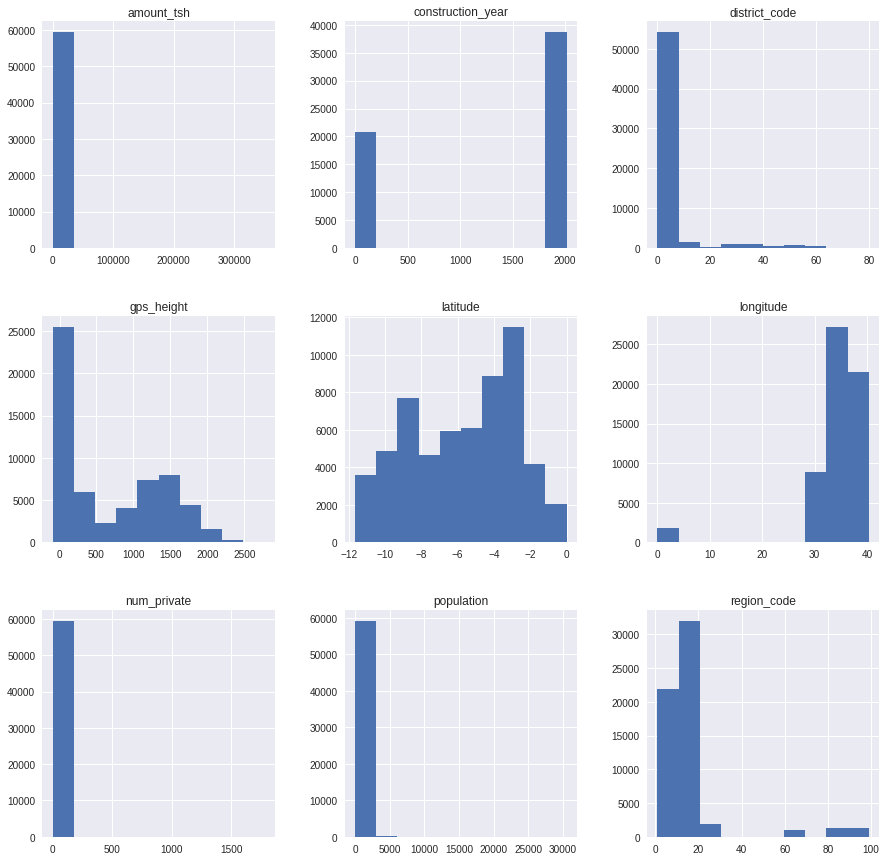

In [7]:
X_raw.hist(figsize=(15,15));

**Not too interesting, but there do seem to be some odd outliers in some**

The latitudes seem to be distributed in a reasonable way, but the longitudes look like they have a couple thousand zeros, which is probably not good

In [8]:
X_raw[X_raw.longitude == 0].shape

(1812, 40)

In every columns where long is zero, it seems like lat is near zero as well

In [9]:
X_raw[(X_raw.longitude == 0) & (X_raw.latitude == -2e-08)].shape

(1812, 40)

It looks like even though our latitude and longitude columns have no NaNs, we have 1812 entries where lat and long are ~0

**Remember** Tanzania's longitudes should be between 29 and 41, latitudes should be between -1 and -12

Now we can load in our shapefiles to make outlines of the country and its 30 regions:

In [10]:
# country outline
tanz_map = geopandas.read_file('../data/shapefiles/TZA_adm0.shp')

# region outline
tanz_regs = geopandas.read_file('../data/shapefiles/TZA_adm1.shp')

In our shapefiles folder we have the TZA_adm0.* files which outline the country, and the TZA_adm1.* files which outline the regions

I'm going to temporarily remove those (0,0) entries to get a sense for the rest of the map, and make the resulting set into a GeoDataFrame

In [11]:
# select only the points with valid lat+long
df_no0 = df.loc[df.longitude != 0]

# make GeoDataFrame
gdf = geopandas.GeoDataFrame(df_no0,
                geometry=geopandas.points_from_xy(df_no0.longitude, df_no0.latitude))


Let's put it all in a map

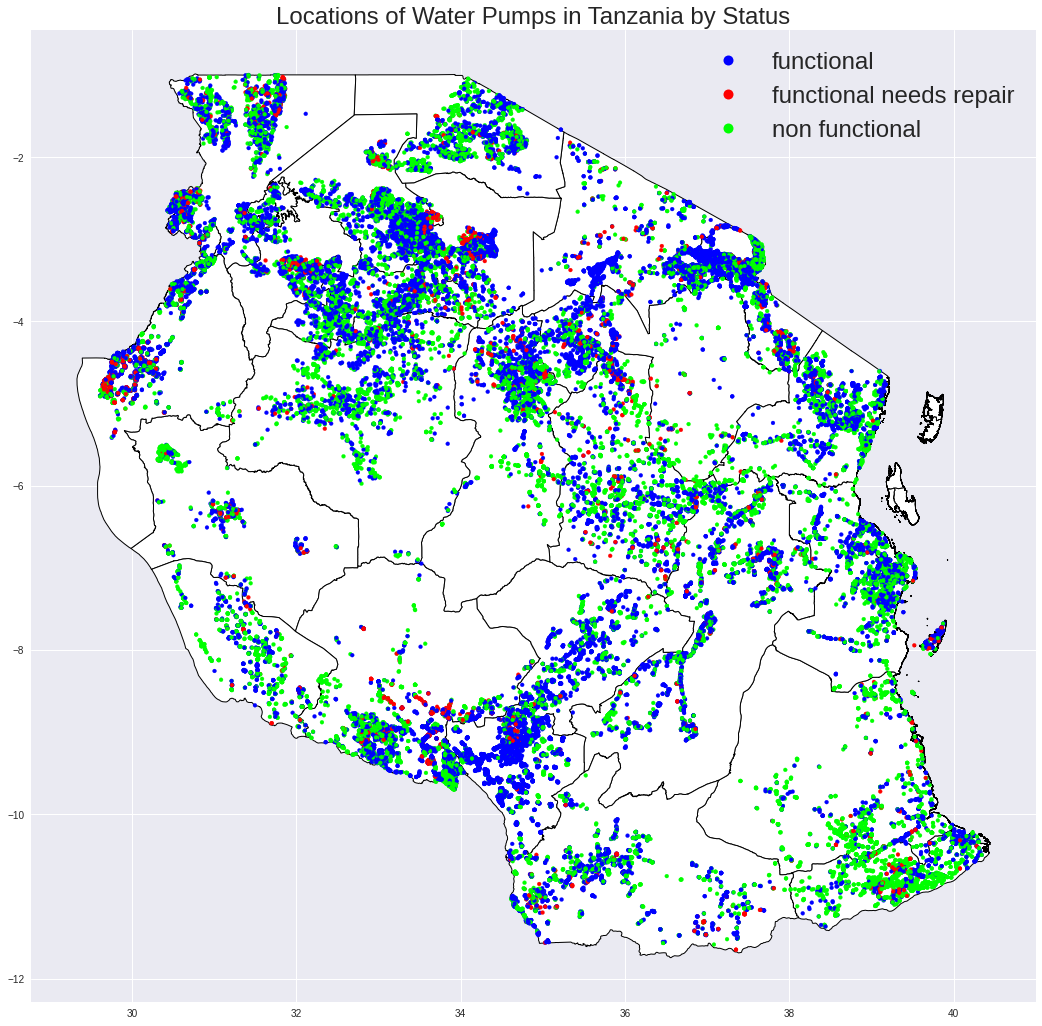

In [14]:
fig, ax = plt.subplots(figsize=(18,18))
ax.set_title('Locations of Water Pumps in Tanzania by Status',
             fontdict={'fontsize':24})

# plots outline of Tanzania
tanz_regs.plot(ax=ax, color='white',
              edgecolor='black', linewidth=1);

# plots locations of pumps on map, colored by status
gdf.plot(ax=ax, column=gdf.status_group,
         markersize=15, cmap='brg',
         legend=True, legend_kwds={'fontsize':24});

# save figure in data folder
# fig.savefig('../data/map_pump_status.png')

Visually, it doesn't seem like there's a huge correlation between geographic location in the country and pump status. Maybe there's a higher proportion of non-functional pumps in the south-eastern regions

I'll just try to see what other columns are intersting right now

**Duplicate columns**
 - quantity / quantity_group
 - payment / payment_type
 
 
 **New thought**
 
 I'm going to get a list of the names and locations of the largest cities in Tanzania, I have found a tidy table on the following url

In [15]:
url = 'https://www.latlong.net/category/cities-220-15.html'
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

Next we can scrape the info from the table

In [16]:
table = [element.get_text() for element in soup.find_all('td')]

Then we'll make one table of city names, and one table that contains Shapely Point objects representing their location

In [17]:
city_names = []
city_points = []

for i in range(0, len(table), 3):
    
    #save city names
    city_names.append(table[i])  
    
    #save city locations as Shapely Points
    long = float(table[i+1])
    lat = float(table[i+2])
    city_points.append(Point(lat,long))
    
#manually adding extra cities
city_names.extend(['Mwanza, Tanzania'])
city_points.extend([Point(32.9175, -2.5164)
                    ])

In the following cell we will calculate the geodesic distance between each water point and the closest major city to it. It uses the shapely distance function to calculate this. The shortest distance will be added to our GeoDataFrame as the column 'distance_from_city'

**Warning:** This cell takes like 5 minutes to run

In [18]:
shortest_distance = []

#iterate through well locations
for well in gdf['geometry']:
    distances = []
    
    #calculate the distances between the well and all 12 cities
    for city in city_points:
        distances.append(distance(city.coords[0],
                                  well.coords[0]).km)
        
    #save the shortest distance
    shortest_distance.append(min(distances))
    
#add our shortest distances to the dataframe
gdf['distance_from_city'] = shortest_distance    

In [19]:
#make points to plot city locations
xs = [point.x for point in city_points]
ys = [point.y for point in city_points]

Next I want to see if our distance calculation is working by plotting it on a color map

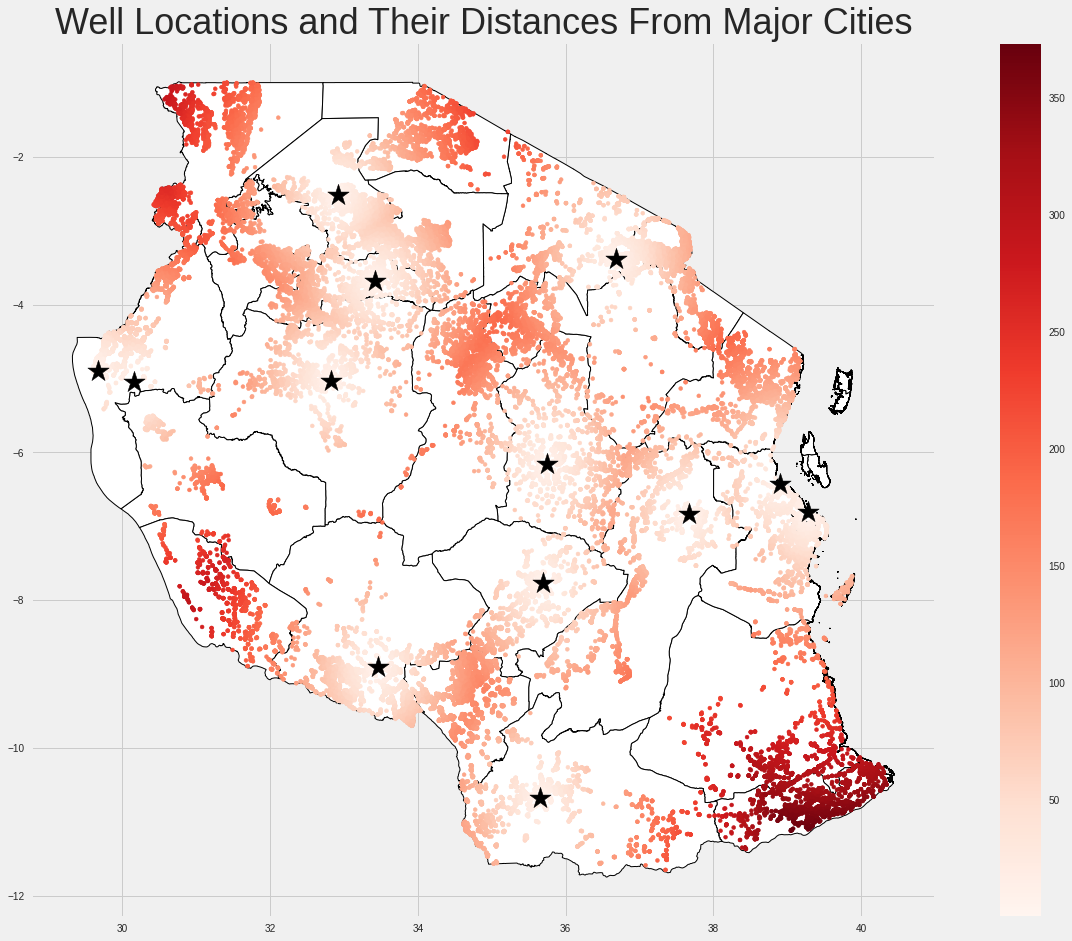

In [20]:

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Well Locations and Their Distances From Major Cities')

#plots outline of Tanzania
tanz_regs.plot(ax=ax, color='white',
              edgecolor='black', linewidth=1);

#plots locations of pumps on map, colored by status
gdf.plot(ax=ax, column=gdf.distance_from_city,
         markersize=15, cmap='Reds',
         legend=True);

#plot major cities
plt.scatter(xs, ys,c='black', marker='*', s=500);
plt.savefig('../reports/figures/distances_from_cities.png', transparent=True)

Looks good! Finally working, we can now see if it can fit in a model, let's check its distribution

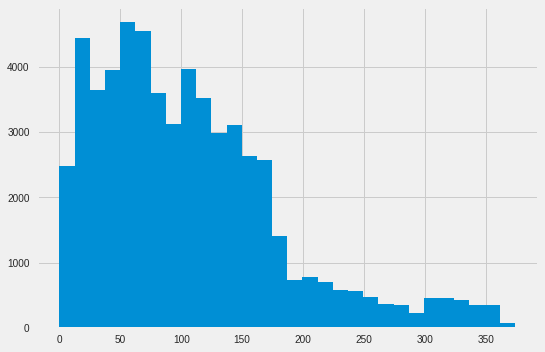

In [21]:
plt.hist((gdf.distance_from_city), bins=30);

In [22]:
gdf.distance_from_city.describe()


count    57588.000000
mean       106.260636
std         75.967317
min          0.153614
25%         49.497525
50%         92.561399
75%        145.724225
max        373.806704
Name: distance_from_city, dtype: float64

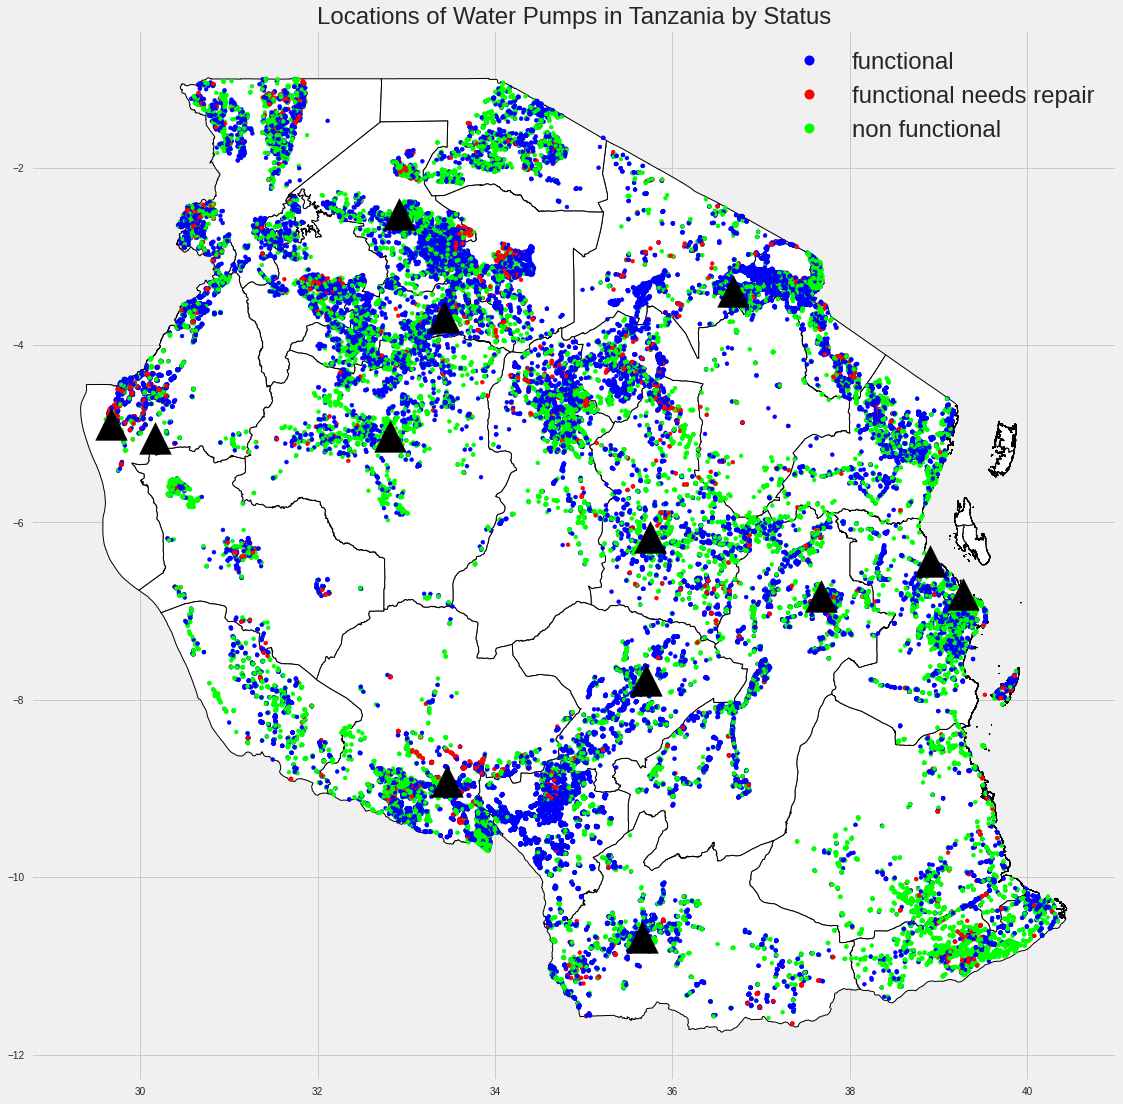

In [23]:
fig, ax = plt.subplots(figsize=(18,18))
ax.set_title('Locations of Water Pumps in Tanzania by Status',
             fontdict={'fontsize':24})

# plots outline of Tanzania
tanz_regs.plot(ax=ax, color='white',
              edgecolor='black', linewidth=1);

# plots locations of pumps on map, colored by status
gdf.plot(ax=ax, column=gdf.status_group,
         markersize=15, cmap='brg',
         legend=True, legend_kwds={'fontsize':24});

#plot major cities
plt.scatter(xs, ys,c='black', marker='^', s=1000);

In [24]:
# close = gdf.loc[gdf.distance_from_city < 75]
n = 248
medium = gdf.loc[(gdf.distance_from_city < n)]
                 
far = gdf.loc[gdf.distance_from_city >=n]

In [25]:
medium.shape, far.shape

((53997, 42), (3591, 42))

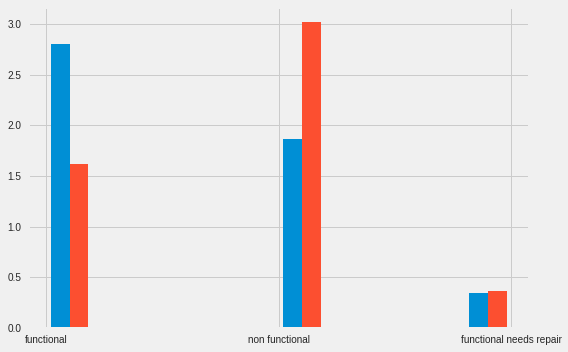

In [26]:

plt.hist([medium.status_group,far.status_group], density=True);

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [28]:
dt = DecisionTreeClassifier(max_depth=1, criterion='entropy')

In [29]:
dt.fit(gdf.distance_from_city.values.reshape(-1,1), gdf.status_group)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

[Text(250.55999999999997, 240.57000000000005, 'X[0] <= 248.404\nentropy = 1.272\nsamples = 57588\nvalue = [31389, 3931, 22268]'),
 Text(125.27999999999999, 80.19, 'entropy = 1.263\nsamples = 54025\nvalue = [30240, 3672, 20113]'),
 Text(375.84, 80.19, 'entropy = 1.24\nsamples = 3563\nvalue = [1149, 259, 2155]')]

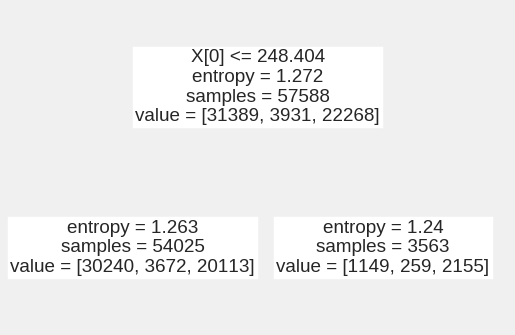

In [30]:
plot_tree(dt)